## Import

In [22]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp


from segmentation_models_pytorch.utils.train import Epoch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import random
import albumentations as albu

import config as cfg

## Dataset

In [23]:
# root_dir = './'
# DATA_DIR_train = os.path.join(root_dir, 'Train')
# DATA_DIR_vail = os.path.join(root_dir, 'Valid')

In [24]:
x_train_dir = os.path.join(cfg.TRAIN_DIR, 'img')
y_train_dir = os.path.join(cfg.TRAIN_DIR,'label')

x_valid_dir = os.path.join(cfg.VALID_DIR, 'img')
y_valid_dir = os.path.join(cfg.VALID_DIR, 'label')

In [25]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [26]:
def fix_randomseed(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    # Cuda
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_randomseed(8863)

In [27]:
class STASDataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        # self.masks_fps[i] = self.masks_fps[i].replace('.jpg','.png')
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape != (800, 800, 3):
            image = cv2.resize(image, (1600, 800), interpolation=cv2.INTER_LANCZOS4)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        if mask.shape != (800, 800, 3):
            mask = cv2.resize(mask, (1600, 800), interpolation=cv2.INTER_LANCZOS4)  
        mask = mask.astype('bool')
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

## Visualize

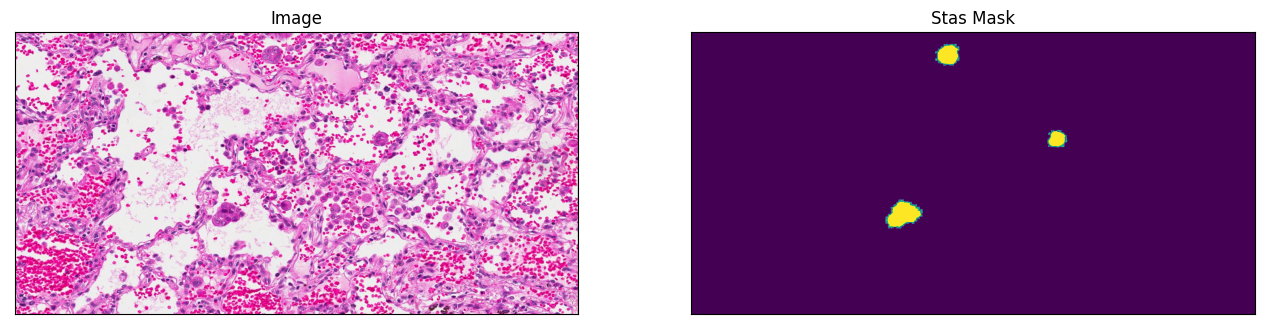

In [28]:
# Lets look at data we have

dataset = STASDataset(x_train_dir, y_train_dir, classes=['stas'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    stas_mask=mask.squeeze(),
)

In [29]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=40,p=0.5,border_mode=cv2.BORDER_CONSTANT),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        
        albu.HueSaturationValue(p=0.6),
        albu.Sharpen(p=0.5),
        albu.RandomBrightnessContrast(p=0.4),

        albu.OneOf([
            albu.ElasticTransform(p=0.5, alpha=120, sigma=120*0.05, alpha_affine=120*0.03),
            albu.GridDistortion(p=0.5),
            albu.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1)
        ]),
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

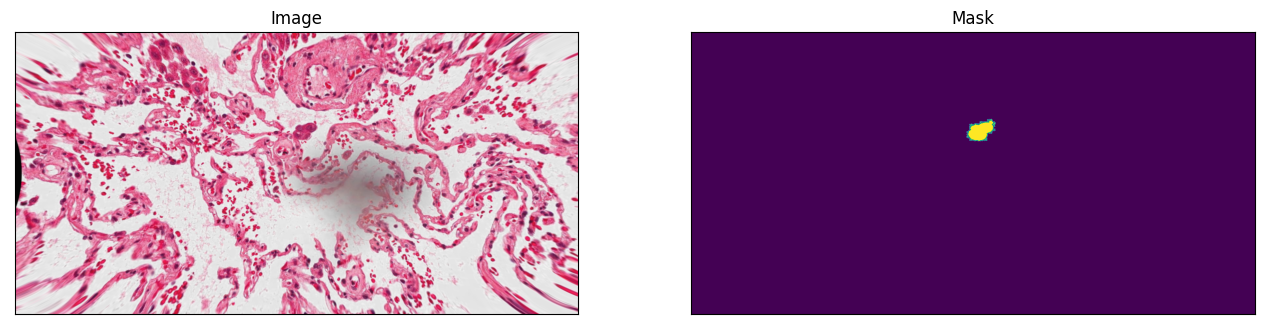

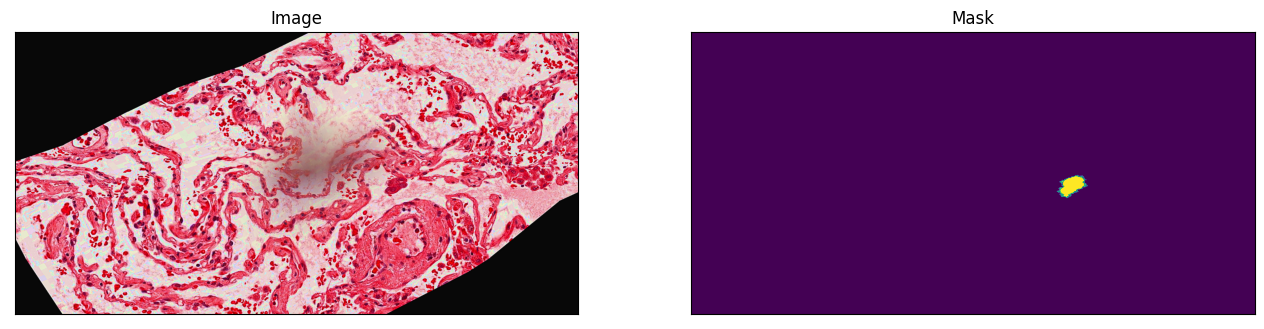

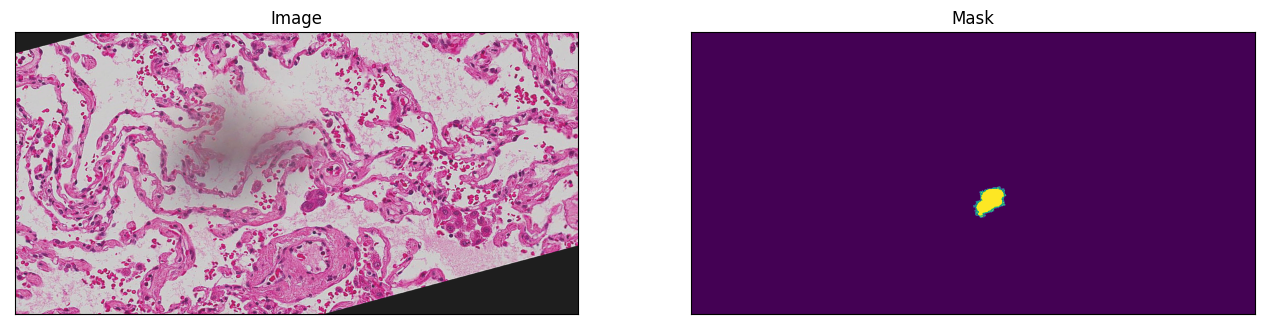

In [30]:
#### Visualize resulted augmented images and masks

augmented_dataset = STASDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['stas'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [31]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'



# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
model = nn.DataParallel(model)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [32]:
train_dataset = STASDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = STASDataset(
    x_valid_dir, 
    y_valid_dir, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, pin_memory=False, batch_size=16, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, pin_memory=False, batch_size=16, shuffle=False, num_workers=8)

In [33]:
## Reference: https://github.com/davda54/sam

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [34]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
loss =smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]
init_lr = 3e-4
base_optimizer = torch.optim.AdamW  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(model.parameters(), base_optimizer, lr=init_lr)

In [35]:
class SAM_TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        # self.optimizer.zero_grad()
        loss = self.loss(self.model.forward(x), y)
        loss.backward()
        self.optimizer.first_step(zero_grad=True)
        prediction = self.model.forward(x)
        self.loss(prediction, y).backward()
        self.optimizer.second_step(zero_grad=True)
        return loss, prediction

In [36]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples

train_epoch = SAM_TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [37]:
path=cfg.MODEL_DIR
os.makedirs(path, exist_ok=True)

# Trainig Epoch

In [ ]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fcore_list = []
EPOCHS = 200

for i in range(EPOCHS):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_loss_list.append(train_logs['bce_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['bce_loss'])
    valid_fcore_list.append(valid_logs['fscore']) 
  

    torch.save(model, path+'Deeplabv3P_resnet50_batch16_new_aug_SAM_epoch200_ori.pth')
    print('Model saved!')
    if i == 100 or i == 150:
        new_lr = init_lr * (1 - (i / EPOCHS))**0.9
        optimizer.param_groups[0]['lr'] = new_lr
        print(f'Decrease decoder learning rate to {new_lr:.5f}!')

## Plot Curve

In [ ]:
plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fcore_list)
plt.title('Train Logs')      
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')


plt.show()

## Single Model Inference

In [38]:
# best_model= torch.load('./Models/Deeplabv3P_resnet50_batch16_new_aug_SAM_epoch200_ori.pth')
best_model = torch.load(os.path.join(cfg.MODEL_DIR, "Deeplabv3P_resnet50_batch16.pth"))
best_model.eval()

DataParallel(
  (module): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (rel

In [39]:
# out_path=os.path.join('./Result', 'Predictions_Deeplabv3P_resnet50_batch16/')
os.makedirs(cfg.SINGLE_PRED_DIR, exist_ok=True)

In [40]:
# inference_dir = os.path.join(root_dir, 'Inference_Images')

In [52]:
class InferenceDataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images_dir,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape != (800, 800, 3):
            image = cv2.resize(image, (1600, 800), interpolation=cv2.INTER_LANCZOS4)

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
            
        return image, self.images_fps[i]
        
    def __len__(self):
        return len(self.ids)

In [53]:
inference_dataset = InferenceDataset(
    cfg.INFERENCE_IMAGE_DIR, 
    preprocessing=get_preprocessing(preprocessing_fn)
)

In [69]:
for i in range(len(inference_dataset)):
    
    name = os.path.basename(inference_dataset.images_fps[i])
    # image_vis = inference_dataset[i][0]
    image = inference_dataset[i][0]
    image_name = inference_dataset[i][1]

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        pr_mask = best_model(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    zeros = np.zeros((800, 1600, 3))
    zeros[...,0] = pr_mask
    zeros[...,1] = pr_mask
    zeros[...,2] = pr_mask
    zeros = cv2.resize(zeros, (1716, 942))
    plt.imsave(os.path.join(cfg.SINGLE_PRED_DIR, name.replace('.jpg','.png')), zeros)
        
    # ori_im = cv2.imread(image_name)
    # ori_im = cv2.cvtColor(ori_im, cv2.COLOR_BGR2RGB)
    # plt.imshow(ori_im)
    # plt.imshow(zeros)

(3, 800, 1600)


## Ensemble Model Inference
上方程式確保模型可正常訓練及進行預測，
且皆固定 Random Seed 為 8863，
下方則可於上方程式執行後，確保已執行 get_model.sh 下載比賽最終使用的 6 個模型，
直接執行取得後處理前的最終預測結果。

In [23]:
# out_path='./Predictions_Ensemble6_th043/'
# os.makedirs(out_path, exist_ok=True)
os.makedirs(cfg.ENSEMBLE_PRED_DIR, exist_ok=True)

In [ ]:
resnet50 = torch.load('./Models/Deeplabv3P_resnet50_batch16.pth')
resnet50.eval()
resnet101 = torch.load('./Models/Deeplabv3P_resnet101_batch12.pth')
resnet101.eval()
resnet152 = torch.load('./Models/Deeplabv3P_resnet152_batch8.pth')
resnet152.eval()
resnext50 = torch.load('./Models/Deeplabv3P_resnext50_batch12.pth')
resnext50.eval()
resnext101 = torch.load('./Models/Deeplabv3P_resnext101_batch8.pth')
resnext101.eval()
se_resnet50 = torch.load('./Models/Deeplabv3P_se_resnet50_batch12.pth')
se_resnet50.eval()

In [25]:
for i in range(len(inference_dataset)):
    name = os.path.basename(inference_dataset.images_fps[i])
    image_vis = inference_dataset[i][0]
    image = inference_dataset[i]
    print(image.shape)
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        pr_mask1 = resnet50(x_tensor)
        pr_mask2 = resnet101(x_tensor)
        pr_mask3 = resnet152(x_tensor)
        pr_mask4 = resnext50(x_tensor)
        pr_mask5 = resnext101(x_tensor)
        pr_mask6 = se_resnet50(x_tensor)
    pr_mask = (pr_mask1 + pr_mask2 + pr_mask3 + pr_mask4 + pr_mask5 + pr_mask6) / 6
    pr_mask += 0.07
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    zeros = np.zeros((800, 1600, 3))
    zeros[...,0] = pr_mask
    zeros[...,1] = pr_mask
    zeros[...,2] = pr_mask
    zeros = cv2.resize(zeros, (1716, 942))
    plt.imsave(os.path.join(cfg.ENSEMBLE_PRED_DIR, name.replace('.jpg','.png')), zeros)

(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1600)
(3, 800, 1

KeyboardInterrupt: 